# Passive Learning Curves

I want to see if training/testing only on compact sources results in a different passive learning curve to training/testing on a mix of compact and non-compact sources.

The first step is to try and isolate a subset of ATLAS objects which are compact. These will probably have a high level of radio agreement, so I'll start by seeing if I can extract a few hundred objects with high agreement.

## Compact sources

In [53]:
from astropy.coordinates import SkyCoord
import h5py
import matplotlib.pyplot as plt
import numpy
import skimage.feature
import sklearn.cross_validation
import sklearn.linear_model
import sklearn.neighbors
import sklearn.pipeline

TRAINING_H5_PATH = '../training.h5'
CROWDASTRO_H5_PATH = '../crowdastro.h5'
NORRIS_DAT_PATH = '../data/norris_2006_atlas_classifications_ra_dec_only.dat'
CLASSIFIER_OUT_PATH = '../classifier.pkl'
ASTRO_TRANSFORMER_OUT_PATH = '../astro_transformer.pkl'
IMAGE_TRANSFORMER_OUT_PATH = '../image_transformer.pkl'
IMAGE_SIZE = 200 * 200
ARCMIN = 1 / 60
N_JOBS = 8

%matplotlib inline

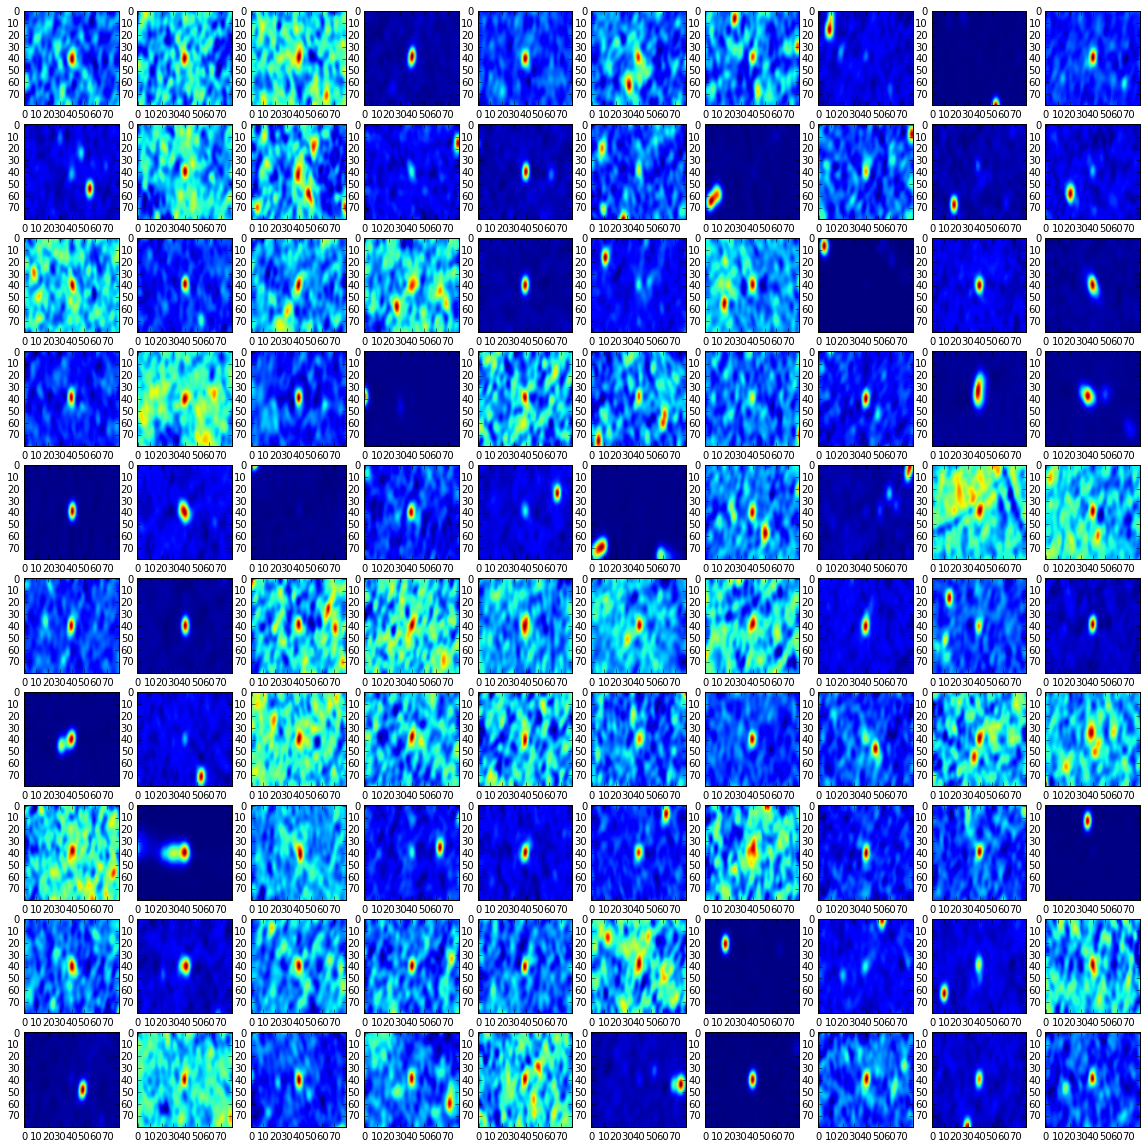

In [44]:
with h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
    atlas_images = crowdastro_h5['/atlas/cdfs/numeric'][:, 2 : 2 + IMAGE_SIZE]
    consensuses = crowdastro_h5['/atlas/cdfs/consensus_objects']
    agreements = consensuses[:, 3]
    high_agreement = (agreements == 1.0).nonzero()[0]
    
    numpy.random.shuffle(high_agreement)
    
    figure = plt.figure(figsize=(20, 20))
    for i, j in enumerate(high_agreement[:100]):
        axis = figure.add_subplot(10, 10, i + 1)
        axis.imshow(atlas_images[j].reshape((200, 200))[60:140, 60:140])
    
    plt.show()

So high agreement doesn't necessarily mean that we have a compact source. What if we pull out everything with one local maximum?

In [45]:
with h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
    atlas_images = crowdastro_h5['/atlas/cdfs/numeric'][:, 2 : 2 + IMAGE_SIZE]
    
    images = []
    one_maximum = []

    for i, image in enumerate(atlas_images):
        image = image.reshape((200, 200))[60:140, 60:140]
        maxima = skimage.feature.peak_local_max(image, threshold_rel=0.2)
        
        if len(maxima) == 1:
            images.append(image)
            one_maximum.append(i)

print('Found {} radio sources with one local maximum.'.format(len(one_maximum)))

Found 462 radio sources with one local maximum.


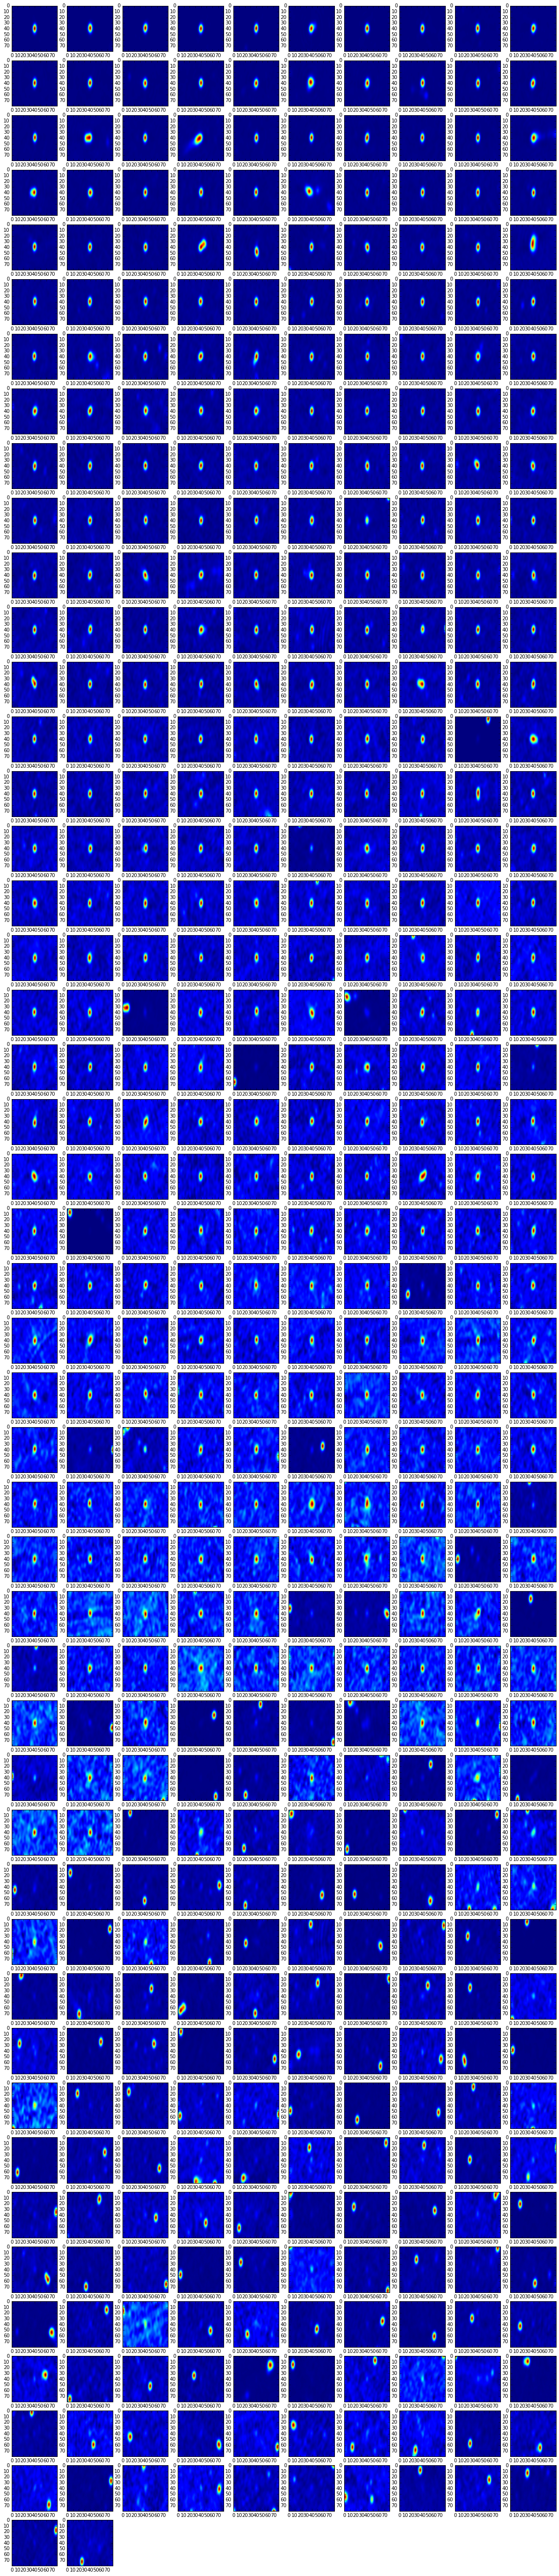

In [46]:
figure = plt.figure(figsize=(20, 47*2))
for i, image in enumerate(images):
    axis = figure.add_subplot(47, 10, i + 1)
    axis.imshow(image)
plt.show()

These are almost all compact. These will form the compact set.

## Passive learning curve for compact sources

In [65]:
# Modified from notebook 40.

# Load labels.
with h5py.File(TRAINING_H5_PATH, 'r') as training_h5:
    crowdsourced_labels = training_h5['labels'].value

with h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
    ir_names = crowdastro_h5['/wise/cdfs/string'].value
    ir_positions = crowdastro_h5['/wise/cdfs/numeric'].value[:, :2]
ir_tree = sklearn.neighbors.KDTree(ir_positions)

with open(NORRIS_DAT_PATH, 'r') as norris_dat:
    norris_coords = [r.strip().split('|') for r in norris_dat]

norris_labels = numpy.zeros((len(ir_positions)))
for ra, dec in norris_coords:
    # Find a neighbour.
    skycoord = SkyCoord(ra=ra, dec=dec, unit=('hourangle', 'deg'))
    ra = skycoord.ra.degree
    dec = skycoord.dec.degree
    ((dist,),), ((ir,),) = ir_tree.query([(ra, dec)])
    if dist < 0.1:
        norris_labels[ir] = 1

def train_and_test(fraction, atlas_train_indices, atlas_test_indices):
    with h5py.File(TRAINING_H5_PATH, 'r') as training_h5, h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
        n_static = 5 if training_h5.attrs['ir_survey'] == 'wise' else 6

        # Only train on IR objects near training radio objects.
        train_indices = numpy.zeros(training_h5['is_ir_train'].shape, dtype=bool)
        for atlas_index in atlas_train_indices:
            ir = crowdastro_h5['/atlas/cdfs/numeric'][atlas_index, n_static + IMAGE_SIZE:]
            nearby = (ir < ARCMIN).nonzero()[0]
            for ir_index in nearby:
                train_indices[ir_index] = 1
        
        # Downsample training indices to match the fraction.
        # This effectively means regenerating the training indices.
        # Start by downsampling the ATLAS training indices.
        n_indices = len(atlas_train_indices)
        numpy.random.shuffle(atlas_train_indices)
        atlas_not_train_indices = atlas_train_indices[int(n_indices * fraction):]
        # Remove all IR objects near removed ATLAS objects.
        for atlas_index in atlas_not_train_indices:
            ir = crowdastro_h5['/atlas/cdfs/numeric'][atlas_index, n_static + IMAGE_SIZE:]
            nearby = (ir < ARCMIN).nonzero()[0]
            for ir_index in nearby:
                train_indices[ir_index] = 0
        print(train_indices.sum(), 'training objects')
        
        # We can now proceed as usual with training/testing.

        outputs = training_h5['labels'].value[train_indices]
        n = len(outputs)

        astro_inputs = numpy.minimum(
                training_h5['features'][train_indices, :n_static], 1500)
        image_inputs = training_h5['features'].value[train_indices, n_static:]

        astro_transformer = sklearn.pipeline.Pipeline([
                ('normalise', sklearn.preprocessing.Normalizer()),
                ('scale', sklearn.preprocessing.StandardScaler()),
        ])
        image_transformer = sklearn.pipeline.Pipeline([
                ('normalise', sklearn.preprocessing.Normalizer()),
        ])

        features = []
        features.append(astro_transformer.fit_transform(astro_inputs))
        features.append(image_transformer.fit_transform(image_inputs))
        inputs = numpy.hstack(features)

        classifier = sklearn.linear_model.LogisticRegression(
                class_weight='balanced', n_jobs=N_JOBS)
        classifier.fit(inputs, outputs)

        numeric_subjects = crowdastro_h5['/atlas/cdfs/numeric'][atlas_test_indices, :]

        n_norris_agree = 0
        n_crowdsourced_agree = 0
        n_all_agree = 0
        n_either_agree = 0
        n_no_host = 0
        n_total = 0
        for subject in numeric_subjects:
            swire = subject[2 + IMAGE_SIZE:]
            nearby = swire < ARCMIN
            astro_inputs = numpy.minimum(training_h5['features'][nearby, :n_static],
                                         1500)
            image_inputs = training_h5['features'][nearby, n_static:]

            features = []
            features.append(astro_transformer.transform(astro_inputs))
            features.append(image_transformer.transform(image_inputs))
            inputs = numpy.hstack(features)

            crowdsourced_outputs = crowdsourced_labels[nearby]
            norris_outputs = norris_labels[nearby]

            if sum(crowdsourced_outputs) < 1 or sum(norris_outputs) < 1:
                # No hosts!
                n_no_host += 1
                continue

            selection = classifier.predict_proba(inputs)[:, 1].argmax()
            n_norris_agree += norris_outputs[selection]
            n_crowdsourced_agree += crowdsourced_outputs[selection]
            n_all_agree += norris_outputs[selection] * crowdsourced_outputs[selection]
            n_either_agree += norris_outputs[selection] or crowdsourced_outputs[selection]
            n_total += 1
    return (n_norris_agree / n_total, n_crowdsourced_agree / n_total,
            n_all_agree / n_total, n_either_agree / n_total)

In [66]:
compact_indices = sorted(one_maximum)
compact_train_indices, compact_test_indices = sklearn.cross_validation.train_test_split(compact_indices, test_size=0.2)

compact_train_indices.sort()
compact_test_indices.sort()

In [67]:
fractions = numpy.linspace(0.05, 1.0, 20)
results = numpy.array([train_and_test(f, compact_train_indices, compact_test_indices) for f in fractions])

147 training objects
375 training objects
597 training objects
680 training objects
977 training objects
1184 training objects
1393 training objects
1514 training objects
1762 training objects
1954 training objects
2202 training objects
2417 training objects
2657 training objects
2910 training objects
3058 training objects
3358 training objects
3542 training objects
3855 training objects
4089 training objects
4363 training objects


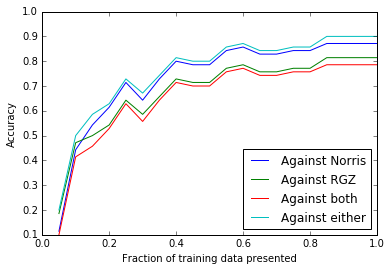

In [68]:
plt.plot(fractions, results[:, 0])
plt.plot(fractions, results[:, 1])
plt.plot(fractions, results[:, 2])
plt.plot(fractions, results[:, 3])
plt.xlabel('Fraction of training data presented')
plt.ylabel('Accuracy')
plt.legend(['Against Norris', 'Against RGZ', 'Against both', 'Against either'], loc='lower right')
plt.show()

## Passive learning curve for other sources

In [70]:
with h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
    n_atlas = crowdastro_h5['/atlas/cdfs/numeric'].shape[0]

non_compact_indices = numpy.array(list(set(range(n_atlas)) - set(compact_indices)))

# Downsample these to have the same count as the compact set.
numpy.random.shuffle(non_compact_indices)
non_compact_indices = non_compact_indices[:len(compact_indices)]

non_compact_train_indices, non_compact_test_indices = sklearn.cross_validation.train_test_split(
        non_compact_indices, test_size=0.2)

non_compact_train_indices.sort()
non_compact_test_indices.sort()

In [72]:
non_compact_results = numpy.array([
        train_and_test(f, non_compact_train_indices, non_compact_test_indices)
        for f in fractions])

213 training objects
457 training objects
738 training objects
991 training objects
1200 training objects
1436 training objects
1672 training objects
1918 training objects
2141 training objects
2465 training objects
2550 training objects
2871 training objects
3153 training objects
3412 training objects
3629 training objects
3946 training objects
4196 training objects
4397 training objects
4690 training objects
4944 training objects


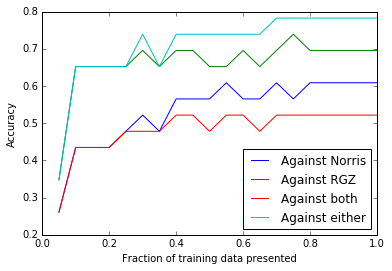

In [73]:
plt.plot(fractions, non_compact_results[:, 0])
plt.plot(fractions, non_compact_results[:, 1])
plt.plot(fractions, non_compact_results[:, 2])
plt.plot(fractions, non_compact_results[:, 3])
plt.xlabel('Fraction of training data presented')
plt.ylabel('Accuracy')
plt.legend(['Against Norris', 'Against RGZ', 'Against both', 'Against either'], loc='lower right')
plt.show()

That seemed to learn quite quickly. I'll rerun both with lower step size.

In [74]:
fractions = numpy.linspace(0.05, 1.0, 40)
compact_results = numpy.array([train_and_test(f, compact_train_indices, compact_test_indices) for f in fractions])
non_compact_results = numpy.array([train_and_test(f, non_compact_train_indices, non_compact_test_indices) for f in fractions])

143 training objects
226 training objects
408 training objects
467 training objects
573 training objects
665 training objects
740 training objects
848 training objects
880 training objects
1048 training objects
1100 training objects
1207 training objects
1314 training objects
1366 training objects
1483 training objects
1675 training objects
1764 training objects
1813 training objects
1895 training objects
2030 training objects
2173 training objects
2310 training objects
2391 training objects
2466 training objects
2550 training objects
2744 training objects
2811 training objects
2875 training objects
2978 training objects
3155 training objects
3293 training objects
3394 training objects
3487 training objects
3625 training objects
3728 training objects
3854 training objects
4013 training objects
4102 training objects
4246 training objects
4363 training objects
224 training objects
348 training objects
452 training objects
633 training objects
752 training objects
835 training objects
886

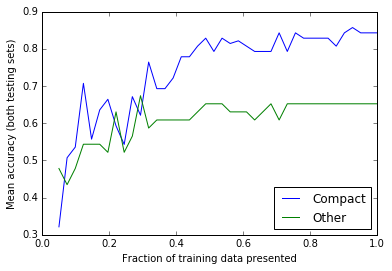

In [81]:
mean_compact_results = (compact_results[:, 0] + compact_results[:, 1]) / 2
mean_non_compact_results = (non_compact_results[:, 0] + non_compact_results[:, 1]) / 2

# Uncomment to scale.
# mean_compact_results -= mean_compact_results.min()
# mean_compact_results /= mean_compact_results.max()
# mean_non_compact_results -= mean_non_compact_results.min()
# mean_non_compact_results /= mean_non_compact_results.max()

plt.plot(fractions, mean_compact_results)
plt.plot(fractions, mean_non_compact_results)
plt.xlabel('Fraction of training data presented')
plt.ylabel('Mean accuracy (both testing sets)')
plt.legend(['Compact', 'Other'], loc='lower right')
plt.show()